In [95]:
import numpy as np
from scipy.spatial import KDTree
from unconstrained import sample_points
from tqdm import trange
import timeit
from numba import jit

In [96]:
def get_arrival_times( rho, max_time=1.0, R=0 ):
    rate = rho*(1+2*R)**2
    Nmax = int(max_time*rate + 2*np.sqrt(max_time*rate)) # Two standard deviations above the mean
    interarrival_times = np.random.exponential(scale=1/rate,size=Nmax)
    arrival_times = np.cumsum(interarrival_times)
    too_late = np.searchsorted(arrival_times,max_time,side='right') # First index where the arrival time is at least max_time
    while too_late == Nmax: # This will be the case if we are unlucky and Nmax points arrived before time max_time. We'll just generate more points.
        interarrival_times = np.append(interarrival_times, np.random.exponential(scale=1/rate,size=Nmax))
        arrival_times = np.cumsum(interarrival_times)
        too_late = np.searchsorted(arrival_times,max_time,side='right') # First index where the arrival time is at least max_time
    return arrival_times[:too_late].copy()

@jit(nopython=True)
def prune_arrivals( times, locations ):
    """
    Given a list of arrival times and locations,
    returns the list of indices which are not covered by earlier points,
    i.e. those which arrived in empty space.
    
    A little slow, but saves a lot of time later.
    """
    N = len(times)
    indices = [0]
    for i in range(1,N):
        covered = False
        x = locations[i]
        t = times[i]
        for j in indices:
            vec = locations[j] - x
            radius2 = t - times[j]
            d2 = np.dot(vec,vec)
            if d2 < radius2:
                covered=True
                break
        if not covered:
            indices.append(i)
    return indices

In [106]:
rho = 1000000

times = get_arrival_times(rho)
seeds = sample_points(len(times))
arrived = prune_arrivals(times, seeds)
print(f'{len(arrived)} out of {len(times)} seeds germinated.')
times = times[arrived]
seeds = seeds[arrived]

697 out of 998186 seeds germinated.


In [107]:
def get_ball_pixels(centre, radius, img_size):
    """
    Returns the indices of the pixels in the picture
    corresponding to a ball centred at a point in [0,1]^2
    of a given radius.
    Also saves the corresponding (squared) distances.
    
    I suspect a numpy-ish method would be faster:
    create a 2d array containing the (squared) distance between each point in [min_i,max_i]x[min_j,max_j]
    and v, then turn that into an array of bools which we can return along with the distances.
    We might need to also then return (min_i, min_j) so the bool array can be aligned within the image.    
    """
    if radius <= 0:
        return [], []
    v = (img_size-1)*centre
    x,y = v[0], v[1]
    r = (img_size-1)*radius
    r2 = r*r
    min_i = max( 0, int(x-r) )
    max_i = min( img_size-1, int(x+r)+1 )
    min_j = max( 0, int(y-r) )
    max_j = min( img_size-1, int(y+r)+1 )
    in_ball = []
    sq_distances = []
    for i in range(min_i, max_i+1):
        dx2 = (x-i)*(x-i)
        if dx2 > r2:
            continue
        w = np.sqrt( r2 - dx2 )
        for j in range(max(int(y-w),min_j), min(int(y+w)+2,max_j+1)):
            d2 = dx2 + (y-j)**2
            if d2 <= r2:
                in_ball.append((i,j))
                sq_distances.append(d2)
    return in_ball, sq_distances

def assign_cells( seeds, times, img_size, T=1.0 ):
    """
    Assigns all the pixels in an img_size x img_size picture
    to their respective Johnson-Mehl cells.
    T should be a decent upper bound on the coverage time - smaller T
    means we check fewer points.
    This is a modified version of Moulinec's algorithm,
    in which we assign things which were covered by time T,
    and leave the rest unassigned.
    """
    min_cov_times = np.full((img_size,img_size),np.inf) # running minimum coverage times
    assignments = np.full((img_size,img_size),-1,dtype=int) # everything uncovered is assigned to a separate class.

    for i in trange(len(times)):
        xi = seeds[i]
        ti = times[i]
        radius = np.sqrt(max(0,T-ti))
        indices, d2s = get_ball_pixels(xi, radius, img_size)
        for k, ij_pair in enumerate(indices):
            cov_time = np.sqrt(np.sqrt(d2s[k])/img_size) + ti
            if cov_time < min_cov_times[ij_pair]:
                assignments[ij_pair] = i
                min_cov_times[ij_pair] = cov_time
    return assignments

In [108]:
img_size = 1920

max_time = 1.5*( (2*np.log(rho) + 4*np.log(np.log(rho))) / (np.pi*rho) )**(1/3)
I = assign_cells(seeds, times, img_size, T=max_time)
# print(I)

100%|█████████████████████████████████████████| 697/697 [06:19<00:00,  1.84it/s]


In [109]:
import networkx # Contains a Graph object which we'll use to store the cell structure.
def get_adjacency(cell_assignments, blanklabel=-1):
    G = networkx.Graph()
    #G.add_nodes_from(range(cell_assignments.max()+1)) # Uncomment this to include cells with zero pixels
    N = cell_assignments.shape[0]
    for i in range(N-1): # All columns except the last
        for j in range(N-1): # All rows except the last
            G.add_edge(cell_assignments[i,j], cell_assignments[i+1,j])
            G.add_edge(cell_assignments[i,j], cell_assignments[i,j+1])
        G.add_edge(cell_assignments[i,N-1],cell_assignments[i+1,N-1])
    for j in range(N-1):
        G.add_edge(cell_assignments[N-1,j],cell_assignments[N-1,j+1])
    G.remove_edges_from(networkx.selfloop_edges(G)) # Not necessary for the colouring but if we want to look at the graph structure it makes it a bit cleaner.
    G.remove_nodes_from([blanklabel]) # If there are uncovered cells, remove them from the adjacency graph.
    return G

In [110]:
cell_structure = get_adjacency(I)
# networkx.draw(cell_structure, with_labels=False, node_size=20)
print(cell_structure)

Graph with 697 nodes and 1999 edges


In [111]:
def colour_graph(G):
    """
    Uses a greedy algorithm to colour G.
    The "colours" are just integers, which can be replaced
    with a suitable set of colours when drawing the picture later.
    Even with a few thousand cells I've never seen it use more than
    7 colours.

    Returns a dictionary indexed by the elements of G.nodes
    """
    cells = list(G.nodes).copy()
    colours = dict.fromkeys(G.nodes)
    
    np.random.shuffle(cells)
    for cell in cells:
        new_colour = 0
        while new_colour in [colours[v] for v in G.neighbors(cell)]:
            new_colour += 1
        colours[cell] = new_colour
    return colours

In [112]:
# # Normally it's possible to find a 5-colouring in a few thousand tries, which is pretty quick.
# # There is a non-zero (but rather small) probability that you'll get a 4-colouring, if you're feeling patient.
colours = colour_graph(cell_structure)

# i=1
# while max(colours.values())+1 > 6:
#     colours = colour_graph(cell_structure)
#     i+=1
# print(f'{i} attempts to get a {max(colours.values())+1}-colouring.')

print(f'We have a {len(set(colours.values()))}-colouring of the cells.')
# networkx.draw(cell_structure, node_size=50, node_color=list(colours.values()))

We have a 6-colouring of the cells.


Next we pick suitable colours.

I might two independent colourings of the cells,
so we have colours of the same luminosity and change the brightnesses.
This means it will be a colourful diagram on the screen but will still have a valid colouring when printed in greyscale.

In [113]:
import colorspace
# c = colorspace.hcl_palettes().get_palette(name="Reds 2")
c = colorspace.hcl_palettes().get_palette(name="Emrld")

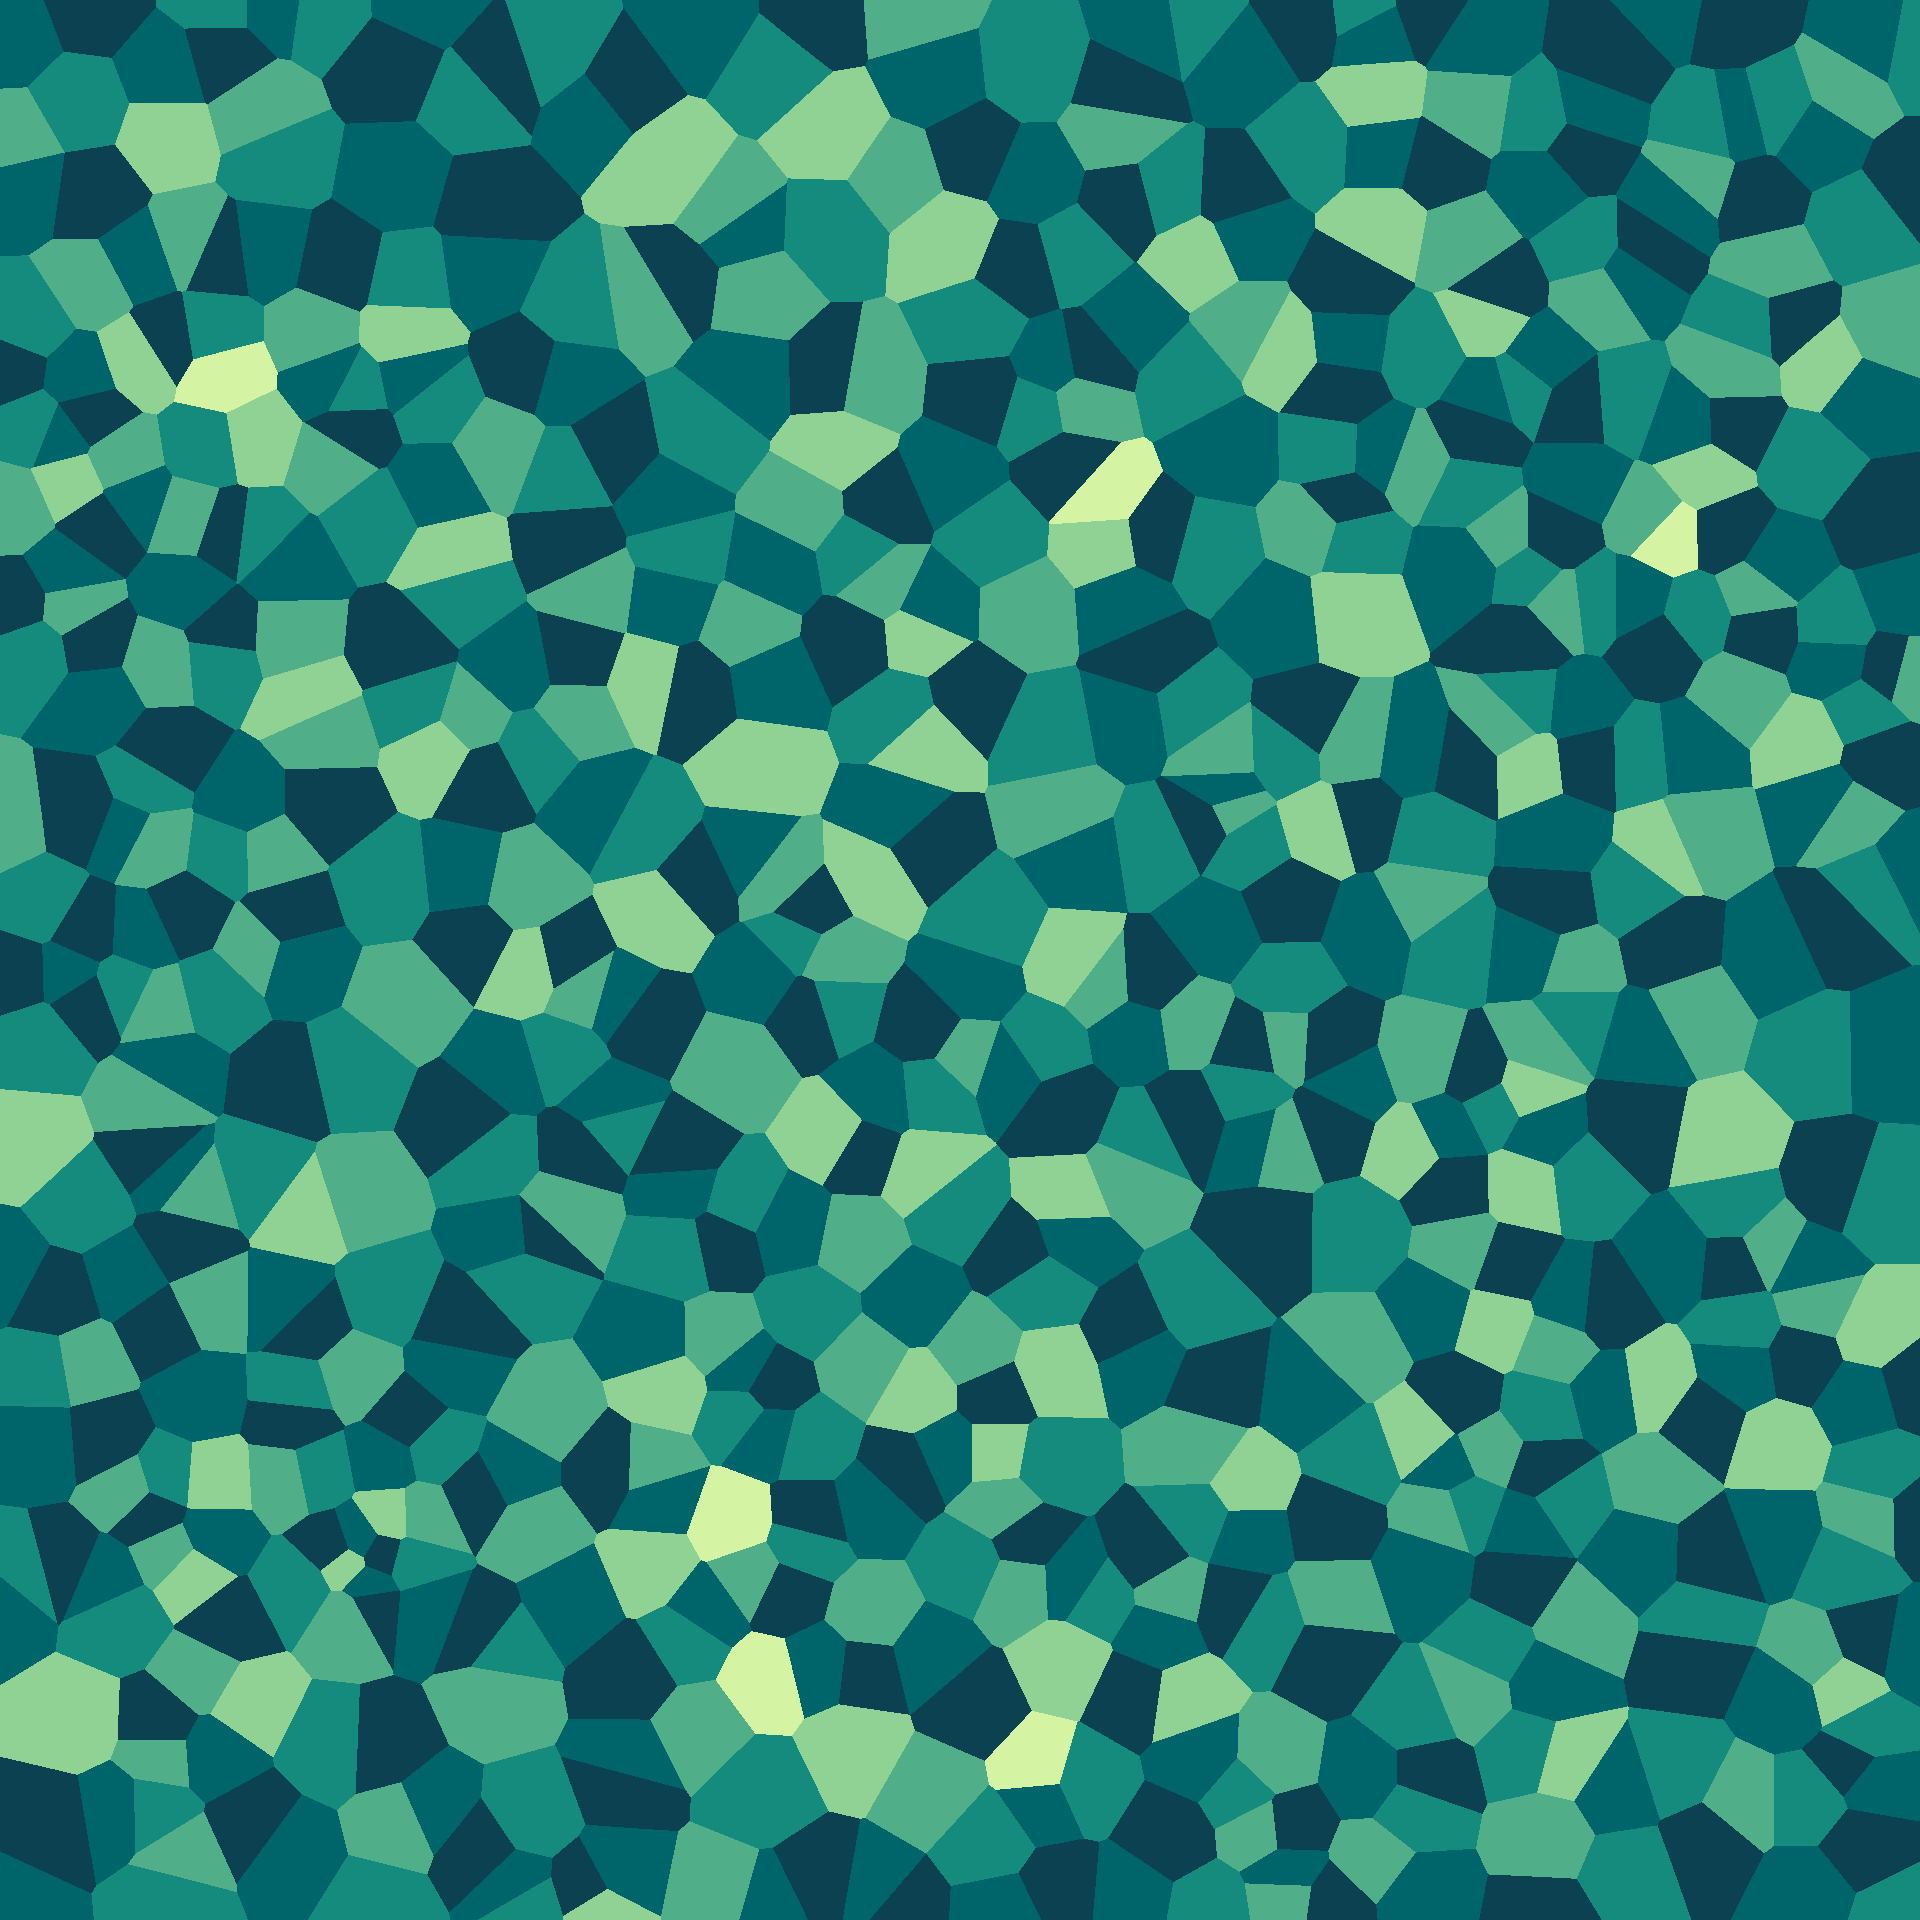

In [114]:
from PIL import Image, ImageColor

hex_colours = c(max(colours.values())+1) # The last colour is for unassigned regions.
rgb_colours = [ImageColor.getcolor(col,"RGB") for col in hex_colours]
bg_colour = (252, 15,192)

data = np.full((img_size, img_size, 3),0, dtype=np.uint8)
N = I.shape[0]
for i in range(N):
    for j in range(N):
        if I[i,j] >= 0:
            data[i,j,:] = rgb_colours[colours[I[i,j]]]
        else:
            data[i,j,:] = bg_colour

image = Image.fromarray(data)
# image.show() # opens in system image viewer
display(image)

In [16]:
image.show()